# Training Different Transfer Models

Training the models without augmentation since there is very little difference with or without.

# Load the data

In [ ]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import zipfile
import shutil


# unzip file
zip_file_path = '/content/SOCOFing.zip'
extracted_path = 'extracted_socofing'

if not os.path.exists(extracted_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

In [ ]:
import data_utils
# Define dataset paths based on the organized structure
organized_dataset_path = 'organized_fingerprint_dataset'
train_dir = os.path.join(organized_dataset_path, 'train')
test_dir = os.path.join(organized_dataset_path, 'test')

# Define image size and batch size
image_size = (224, 224)
batch_size = 10

# Create training dataset from the 'train' directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Create validation dataset from the test directory
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,  # Do not shuffle validation data
    seed=42
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and prefetched without data augmentation.")

Found 160 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Class names: ['Altered', 'Real']
Datasets loaded and prefetched without data augmentation.


## Train MobileNetV2 Model

In [ ]:
from keras.applications import MobileNetV2

# Load the MobileNetV2 model
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_size + (3,))

# Freeze the base model layers
for layer in base_model_mobilenetv2.layers:
    layer.trainable = False

# Create the new model on top of the base model
inputs = keras.Input(shape=image_size + (3,))
x = base_model_mobilenetv2(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation=None)(x)
mobilenetv2_model = keras.Model(inputs, outputs)


# Compiling and training the model
mobilenetv2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
history_mobilenetv2 = mobilenetv2_model.fit(
    train_ds,
    callbacks=callbacks,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - acc: 0.5035 - loss: 0.8461 - val_acc: 0.4750 - val_loss: 0.6835
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - acc: 0.4701 - loss: 0.7728 - val_acc: 0.5750 - val_loss: 0.6479
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - acc: 0.5433 - loss: 0.7201 - val_acc: 0.5250 - val_loss: 0.6244
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 549ms/step - acc: 0.6264 - loss: 0.7115 - val_acc: 0.5750 - val_loss: 0.6030
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - acc: 0.6438 - loss: 0.6753 - val_acc: 0.5250 - val_loss: 0.5863
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - acc: 0.6354 - loss: 0.6763 - val_acc: 0.5500 - val_loss: 0.5768
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step - acc: 0.6646 - loss: 0.6245 - val_acc: 0.5500 - val_loss: 0.5640
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - acc: 0.7085 - loss: 0.5513 - val_acc: 0.5500 - val_loss: 0.5527
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step -

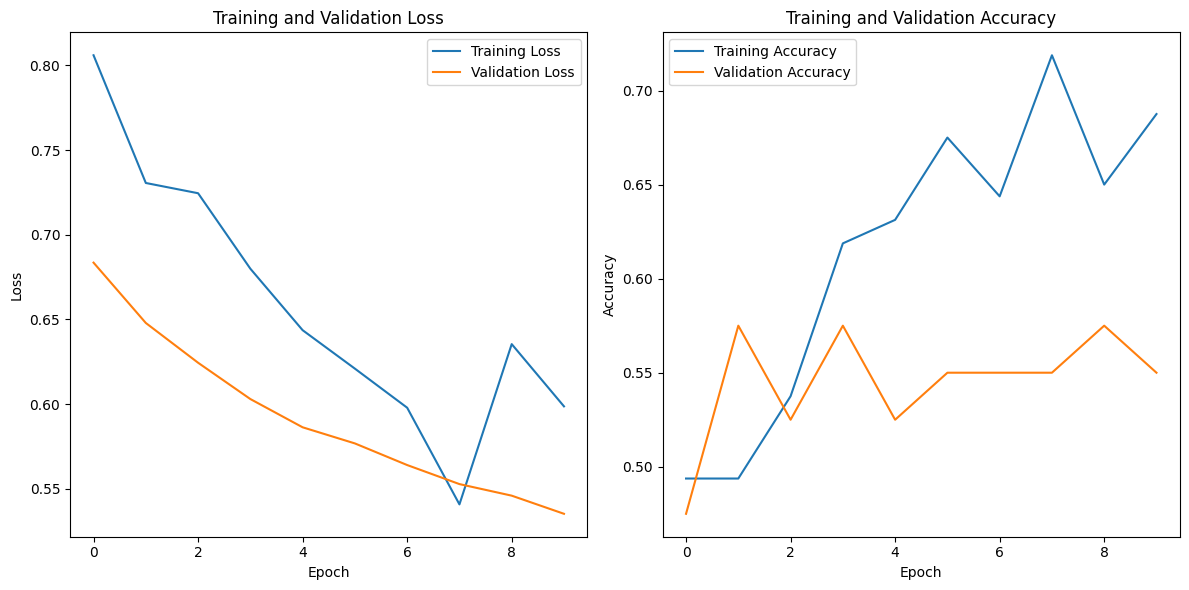

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['loss'], label='Training Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['acc'], label='Training Accuracy')
plt.plot(history_mobilenetv2.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
mobilenetv2_model.save('base_mobilenetv2.keras')

In [ ]:
# Evaluate the MobileNetV2 model on the validation dataset
mobilenetv2_eval_results = mobilenetv2_model.evaluate(val_ds)

# Print the validation loss and accuracy
print(f"MobileNetV2 Validation Loss: {mobilenetv2_eval_results[0]:.4f}")
print(f"MobileNetV2 Validation Accuracy: {mobilenetv2_eval_results[1]:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - acc: 0.6567 - loss: 0.5285
MobileNetV2 Validation Loss: 0.5352
MobileNetV2 Validation Accuracy: 0.5500


Analysis:

The model training accuracy was increasing and peaked at epoch 8 with about 71% accuracy, but then decreased down to 67% accuracy. The validation accuracy was highest at about 58% at 3 different epochs, but ultimately dwindled down to 55%. Both the training and validation loss steadily decreased.
The MobileNetV2 model compared to the base ResNet50 performed about the same for training accuracy but significantly worse for the validation accuracy.